In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch

import object_placement_utils as utils
from src.eunms import Model_Type, Scheduler_Type
from src.utils.enums_utils import get_pipes
from src.config import RunConfig

/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarnin

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_type = Model_Type.SDXL_Turbo
scheduler_type = Scheduler_Type.EULER
pipe_inversion, pipe_inference = get_pipes(model_type, scheduler_type, device=device)

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLImg2ImgPipeline and will be ignored.
Loading pipeline components...:  86%|████████▌ | 6/7 [00:01<00:00,  5.25it/s]/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]


In [5]:
config = RunConfig(
    model_type=model_type,
    scheduler_type=scheduler_type,
    noise_regularization_lambda_kl=0.01,
    noise_regularization_lambda_ac=10,
    # noise_regularization_lambda_kl=0.5,
    # noise_regularization_lambda_ac=80,
    num_inversion_steps=4,
    num_inference_steps=4,
    # num_renoise_steps=9,
)

In [22]:
images_dir = "example_images/mini_benchmark"
bg_images, original_prompts = utils.get_generated_bg_images_and_prompts(images_dir)
object_names = utils.get_object_names(images_dir)

In [8]:
llava_model, llava_processor = utils.get_llava_model_and_processor(device)

Loading checkpoint shards: 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [25]:
query_format = "USER: <image>\nhere is the caption to the image: '{original_prompt}'. modify it so it includes {object_name}. ASSISTANT:"
edit_prompts = utils.get_edit_prompts(
    llava_processor,
    llava_model,
    query_format,
    bg_images,
    object_names,
    original_prompts,
    device,
)

In [28]:
inv_latents, noises = utils.invert_images(
    config=config,
    pipe_inversion=pipe_inversion,
    pipe_inference=pipe_inference,
    images=bg_images,
    prompts=original_prompts,
)

Inverting...


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Inverting...


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Inverting...


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Inverting...


100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Inverting...


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Inverting...


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Inverting...


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Inverting...


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Inverting...


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Inverting...


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Inverting...


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Inverting...


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


In [29]:
pipe_inference = utils.set_pipe_for_cross_attn_logging(pipe_inference)

In [30]:
indices = [8, 12, 18, 13, 18, 25, 34, 24, 17, 11, 16, 10]  # TODO - move to function

In [34]:
edit_images, attn_maps = utils.get_edit_images_and_attn_maps(
    config=config,
    pipe_inference=pipe_inference,
    inv_latents=inv_latents,
    noises=noises,
    inversion_prompts=original_prompts,
    edit_prompts=edit_prompts,
    indices=indices,
)

100%|██████████| 4/4 [00:00<00:00,  6.52it/s]


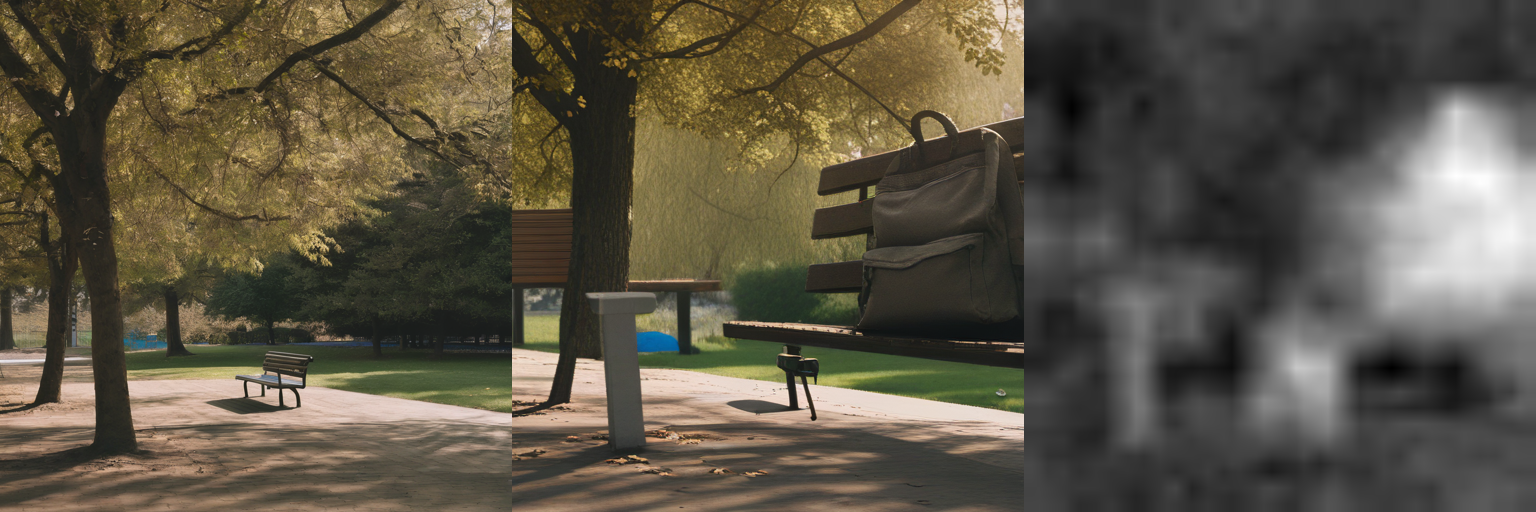

In [35]:
from diffusers.utils import make_image_grid

make_image_grid([bg_images[0], edit_images[0], attn_maps[0]], 1, 3)